In [1]:
# !pip install spacy

# !pip install word2vec

# # Elementos a utilizar
import nltk

nltk.download("webtext")
from nltk.corpus import webtext

nltk.download("stopwords")

print("the data contained in the webtext is :", webtext.fileids())


the data contained in the webtext is : ['firefox.txt', 'grail.txt', 'overheard.txt', 'pirates.txt', 'singles.txt', 'wine.txt']


[nltk_data] Downloading package webtext to /home/dante/nltk_data...
[nltk_data]   Package webtext is already up-to-date!
[nltk_data] Downloading package stopwords to /home/dante/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# utilizar la información del webchat de firefox
firefox = webtext.raw("firefox.txt")
print(firefox[:500])

firefox_sents = firefox.split("\n")
print(
    "el número de frases convertidas a partir del fichero de datos brutos es de:",
    len(firefox_sents),
)


Cookie Manager: "Don't allow sites that set removed cookies to set future cookies" should stay checked
When in full screen mode
Pressing Ctrl-N should open a new browser when only download dialog is left open
add icons to context menu
So called "tab bar" should be made a proper toolbar or given the ability collapse / expand.
[XUL] Implement Cocoa-style toolbar customization.
#ifdefs for MOZ_PHOENIX
customize dialog's toolbar has small icons when small icons is not checked
nightly builds 
el número de frases convertidas a partir del fichero de datos brutos es de: 10002


In [3]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

In [5]:
# limpieza de los datos
Stopwords = stopwords.words("english")
import re

charfilter = re.compile("[a-zA-Z]+")

# tokenizar las palabras
def simple_filter(sent):
    # convertir todos los tokens a minúsculas:
    words = sent.split()
    word_lower = []
    for word in words:
        word_lower.append(word.lower())
    # eliminar todas las stopwords
    # eliminar caracteres
    tokens = list(filter(lambda token: charfilter.match(token), word_lower))
    # stemming de las palabras
    ntokens = []
    for word in tokens:
        ntokens.append(PorterStemmer().stem(word))
    return " ".join(tokens)


# convertir todos los datos de bryant a tokens utilizando nuestra función simple tokenizer
sentences = []
for sent in firefox_sents:
    tokens = simple_filter(sent)
    if len(tokens) > 0:
        sentences.append(tokens)

# Sense2Vec
# usar Spacy para calcular las etiquetas de POS de cada palabra
import spacy

nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

docs = []
count = 0
for item in sentences:
    docs.append(nlp(item))
    count += 1
sense_corpus = [[x.text + "_" + x.pos_ for x in y] for y in docs]

print(sense_corpus[:5])

[['cookie_NOUN', 'manager_NOUN', ':_PUNCT', 'allow_VERB', 'sites_NOUN', 'that_PRON', 'set_VERB', 'removed_VERB', 'cookies_NOUN', 'to_PART', 'set_VERB', 'future_ADJ', 'cookies_NOUN', '"_PUNCT', 'should_AUX', 'stay_VERB', 'checked_VERB'], ['when_SCONJ', 'in_ADP', 'full_ADJ', 'screen_NOUN', 'mode_NOUN'], ['pressing_VERB', 'ctrl_NOUN', '-_PUNCT', 'n_NOUN', 'should_AUX', 'open_VERB', 'a_DET', 'new_ADJ', 'browser_NOUN', 'when_SCONJ', 'only_ADV', 'download_NOUN', 'dialog_NOUN', 'is_AUX', 'left_VERB', 'open_ADJ'], ['add_VERB', 'icons_NOUN', 'to_PART', 'context_VERB', 'menu_NOUN'], ['so_ADV', 'called_VERB', 'bar_NOUN', '"_PUNCT', 'should_AUX', 'be_AUX', 'made_VERB', 'a_DET', 'proper_ADJ', 'toolbar_NOUN', 'or_CCONJ', 'given_VERB', 'the_DET', 'ability_NOUN', 'collapse_NOUN', 'expand_NOUN', '._PUNCT']]


In [6]:
# Ahora, utilizar el modelo word2vec en el corpus de sentidos creado
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

In [7]:
# Los modelos colocados como comentarios son distintas formas de generar el modelado
model_skipgram = Word2Vec(
    sense_corpus, min_count=1, vector_size=50, workers=3, window=5, sg=1
)
# model_w2v = Word2Vec(sense_corpus,vector_size=200)
# model_skipgram  = Word2Vec(sentences=sense_corpus, vector_size=100, window=5, min_count=1, workers=4)

model_skipgram

In [8]:
import warnings

warnings.filterwarnings("ignore")

# Ahora, utilizar el modelo word2vec en el corpus de sentidos creado
from gensim.models import Word2Vec
model_skipgram = Word2Vec(
    sense_corpus, min_count=1, vector_size=50, workers=3, window=5, sg=1
)

# Configura los hiperparámetros del modelo
model = Word2Vec(
    sentences=sense_corpus, vector_size=100, window=5, min_count=1, sg=0, workers=4
)

# Entrena el modelo
model.train(sense_corpus, total_examples=model.corpus_count, epochs=100)

(7194764, 8990000)

In [9]:
"""Observar la similitud entre palabras, web o internet por ejemplo"""

similar_words = model.wv.most_similar("web_NOUN", "internet_NOUN")
print(similar_words)

[('yellow_ADJ', 0.39410096406936646), ('targeting_VERB', 0.36169153451919556), ('type="text_NOUN', 0.3453056514263153), ('originating_VERB', 0.3171626031398773), ('images_NOUN', 0.31467631459236145), ('secure_ADJ', 0.31043317914009094), ('forms_NOUN', 0.3018953204154968), ('label_PROPN', 0.2998413145542145), ('light_ADJ', 0.295396089553833), ('transparent_ADJ', 0.29115965962409973)]


In [10]:
similar_words = model.wv.most_similar("web_NOUN", topn=3)
print(similar_words)

[('secure_ADJ', 0.4368716776371002), ('images_NOUN', 0.3975785970687866), ('tools->options->web_PROPN', 0.38101664185523987)]


In [15]:
# Suponiendo que tienes un modelo Word2Vec entrenado con skip-gram
from gensim.models import Word2Vec

# Acceder al vocabulario
vocab = model_skipgram.wv.key_to_index

# Verificar si una palabra está en el vocabulario
if "web_NOUN" in vocab:
    print("La palabra 'web_NOUN' está en el vocabulario.")
else:
    print("La palabra 'ejemplo' no está en el vocabulario.")

La palabra 'ejemplo' no está en el vocabulario.


In [16]:
# Obtener el vector de una palabra
vector = model_skipgram.wv["web_NOUN"]
print("Vector de la palabra 'ejemplo':", vector)

Vector de la palabra 'ejemplo': [ 0.20998631 -0.05159295 -0.17363046  0.01333371 -0.17676245 -0.20438169
  0.50866973  0.42569208 -0.696034   -0.40517777  0.21922593 -0.4436206
 -0.0274884   0.15872373 -0.46336293  0.22535248  0.39258802  0.36837572
 -0.5514154  -0.16481183  0.23443472  0.17602171  0.6633989  -0.04072062
  0.13837825 -0.04081215  0.14980936  0.0925773  -0.23306607 -0.00213306
  0.08439373 -0.38235942 -0.21668941 -0.4237759  -0.2730774  -0.23191471
  0.41544002  0.29597163  0.07233777 -0.47382656  0.01628303 -0.164642
 -0.01193443 -0.22997336  0.81075215  0.32306334  0.2902086  -0.44048432
 -0.02901866  0.24021144]


In [17]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Suponiendo que se tiene un modelo Word2Vec entrenado
from gensim.models import Word2Vec

# Cargar o entrenar el modelo

# Obtener los vectores de palabras y sus etiquetas
words = []
vectors = []
for word in model_skipgram.wv.key_to_index:
    words.append(word)
    vectors.append(model_skipgram.wv[word])

# Realizar reducción de dimensionalidad con PCA
pca = PCA(n_components=2)
vectors_2d = pca.fit_transform(vectors)

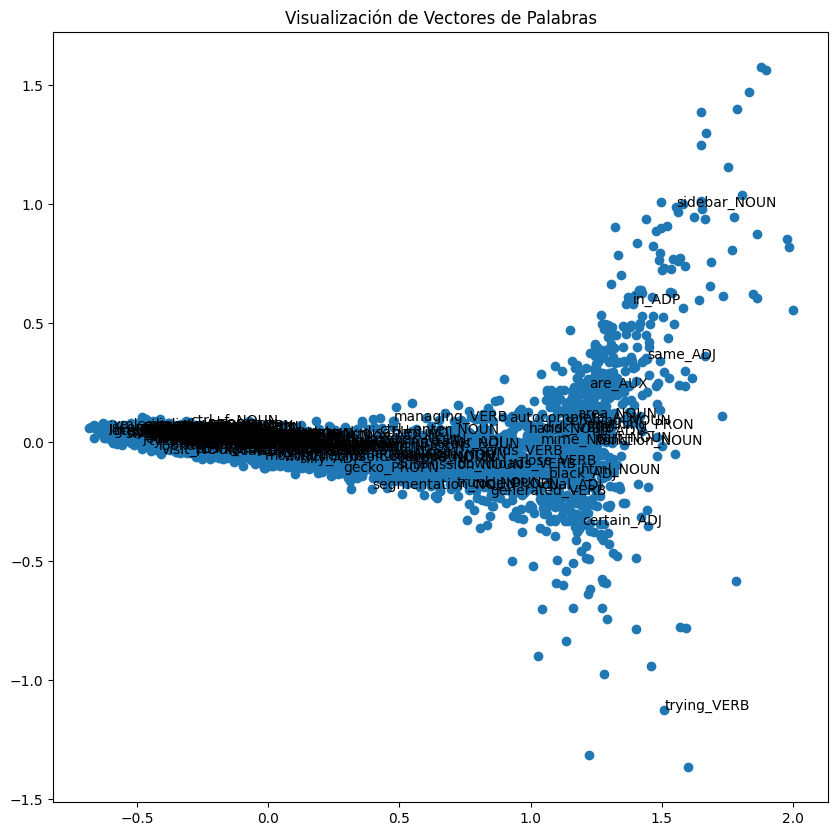

In [18]:
# Alternativamente, puedes usar t-SNE para una mejor visualización
# t-SNE suele funcionar mejor que PCA para visualizar en 2D
# t-SNE puede tardar más en ejecutarse
# tsne = TSNE(n_components=2)
# vectors_2d = tsne.fit_transform(vectors)

# Crear un gráfico de dispersión para visualizar los vectores de palabras
plt.figure(figsize=(10, 10))
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1])

# Etiquetar algunos puntos en el gráfico para palabras específicas
for i, word in enumerate(words):
    if i % 50 == 0: 
        plt.annotate(word, (vectors_2d[i, 0], vectors_2d[i, 1]))

plt.title("Visualización de Vectores de Palabras")
plt.show()

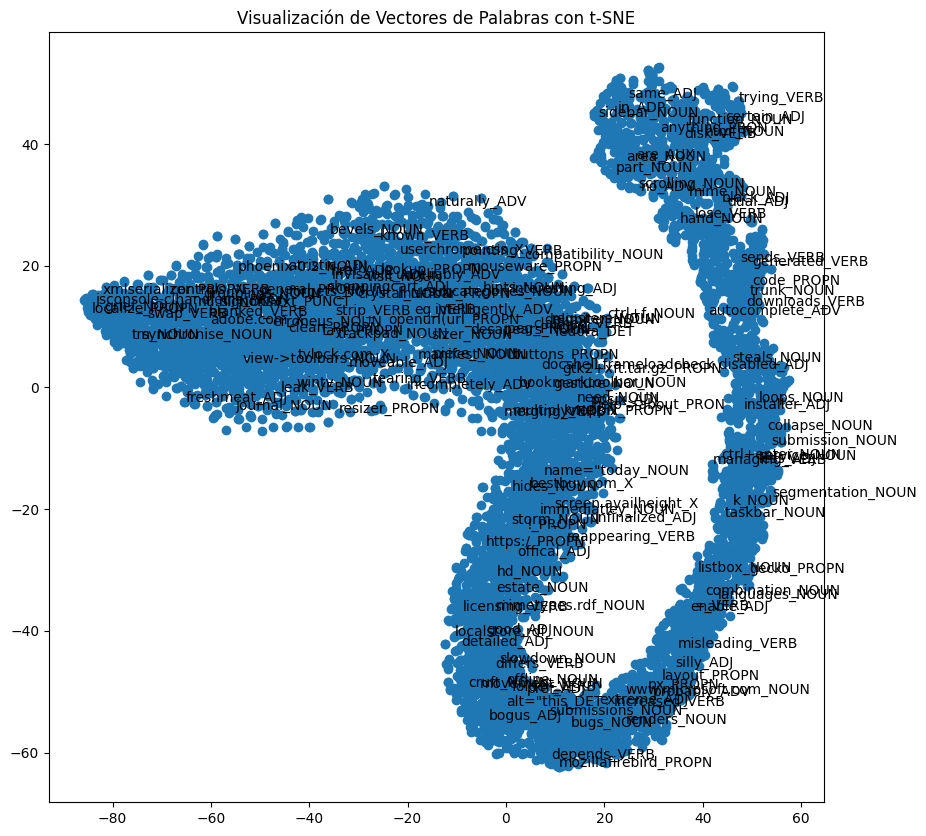

In [19]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Suponiendo que tienes un modelo Word2Vec entrenado
from gensim.models import Word2Vec

# Cargar o entrenar el modelo

# Obtener los vectores de palabras y sus etiquetas
words = []
vectors = []
for word in model_skipgram.wv.key_to_index:
    words.append(word)
    vectors.append(model_skipgram.wv[word])

# Convertir la lista de listas a un arreglo NumPy
vectors = np.array(vectors)

# Realizar reducción de dimensionalidad con t-SNE
tsne = TSNE(n_components=2, random_state=42)
vectors_2d = tsne.fit_transform(vectors)

# Crear un gráfico de dispersión para visualizar los vectores de palabras
plt.figure(figsize=(10, 10))
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1])

# Etiquetar algunos puntos en el gráfico para palabras específicas
for i, word in enumerate(words):
    if i % 50 == 0:
        plt.annotate(word, (vectors_2d[i, 0], vectors_2d[i, 1]))

plt.title("Visualización de Vectores de Palabras con t-SNE")
plt.show()
